In [53]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

## 相位噪声模拟  
时间分辨率1us，采样率1MHz，模拟时间1s  
用布朗运动模拟相位噪声

      phase speed      phase
Mean    -0.000003 -10.174578
Std      0.013941   3.978187
Var      0.000194  15.825972


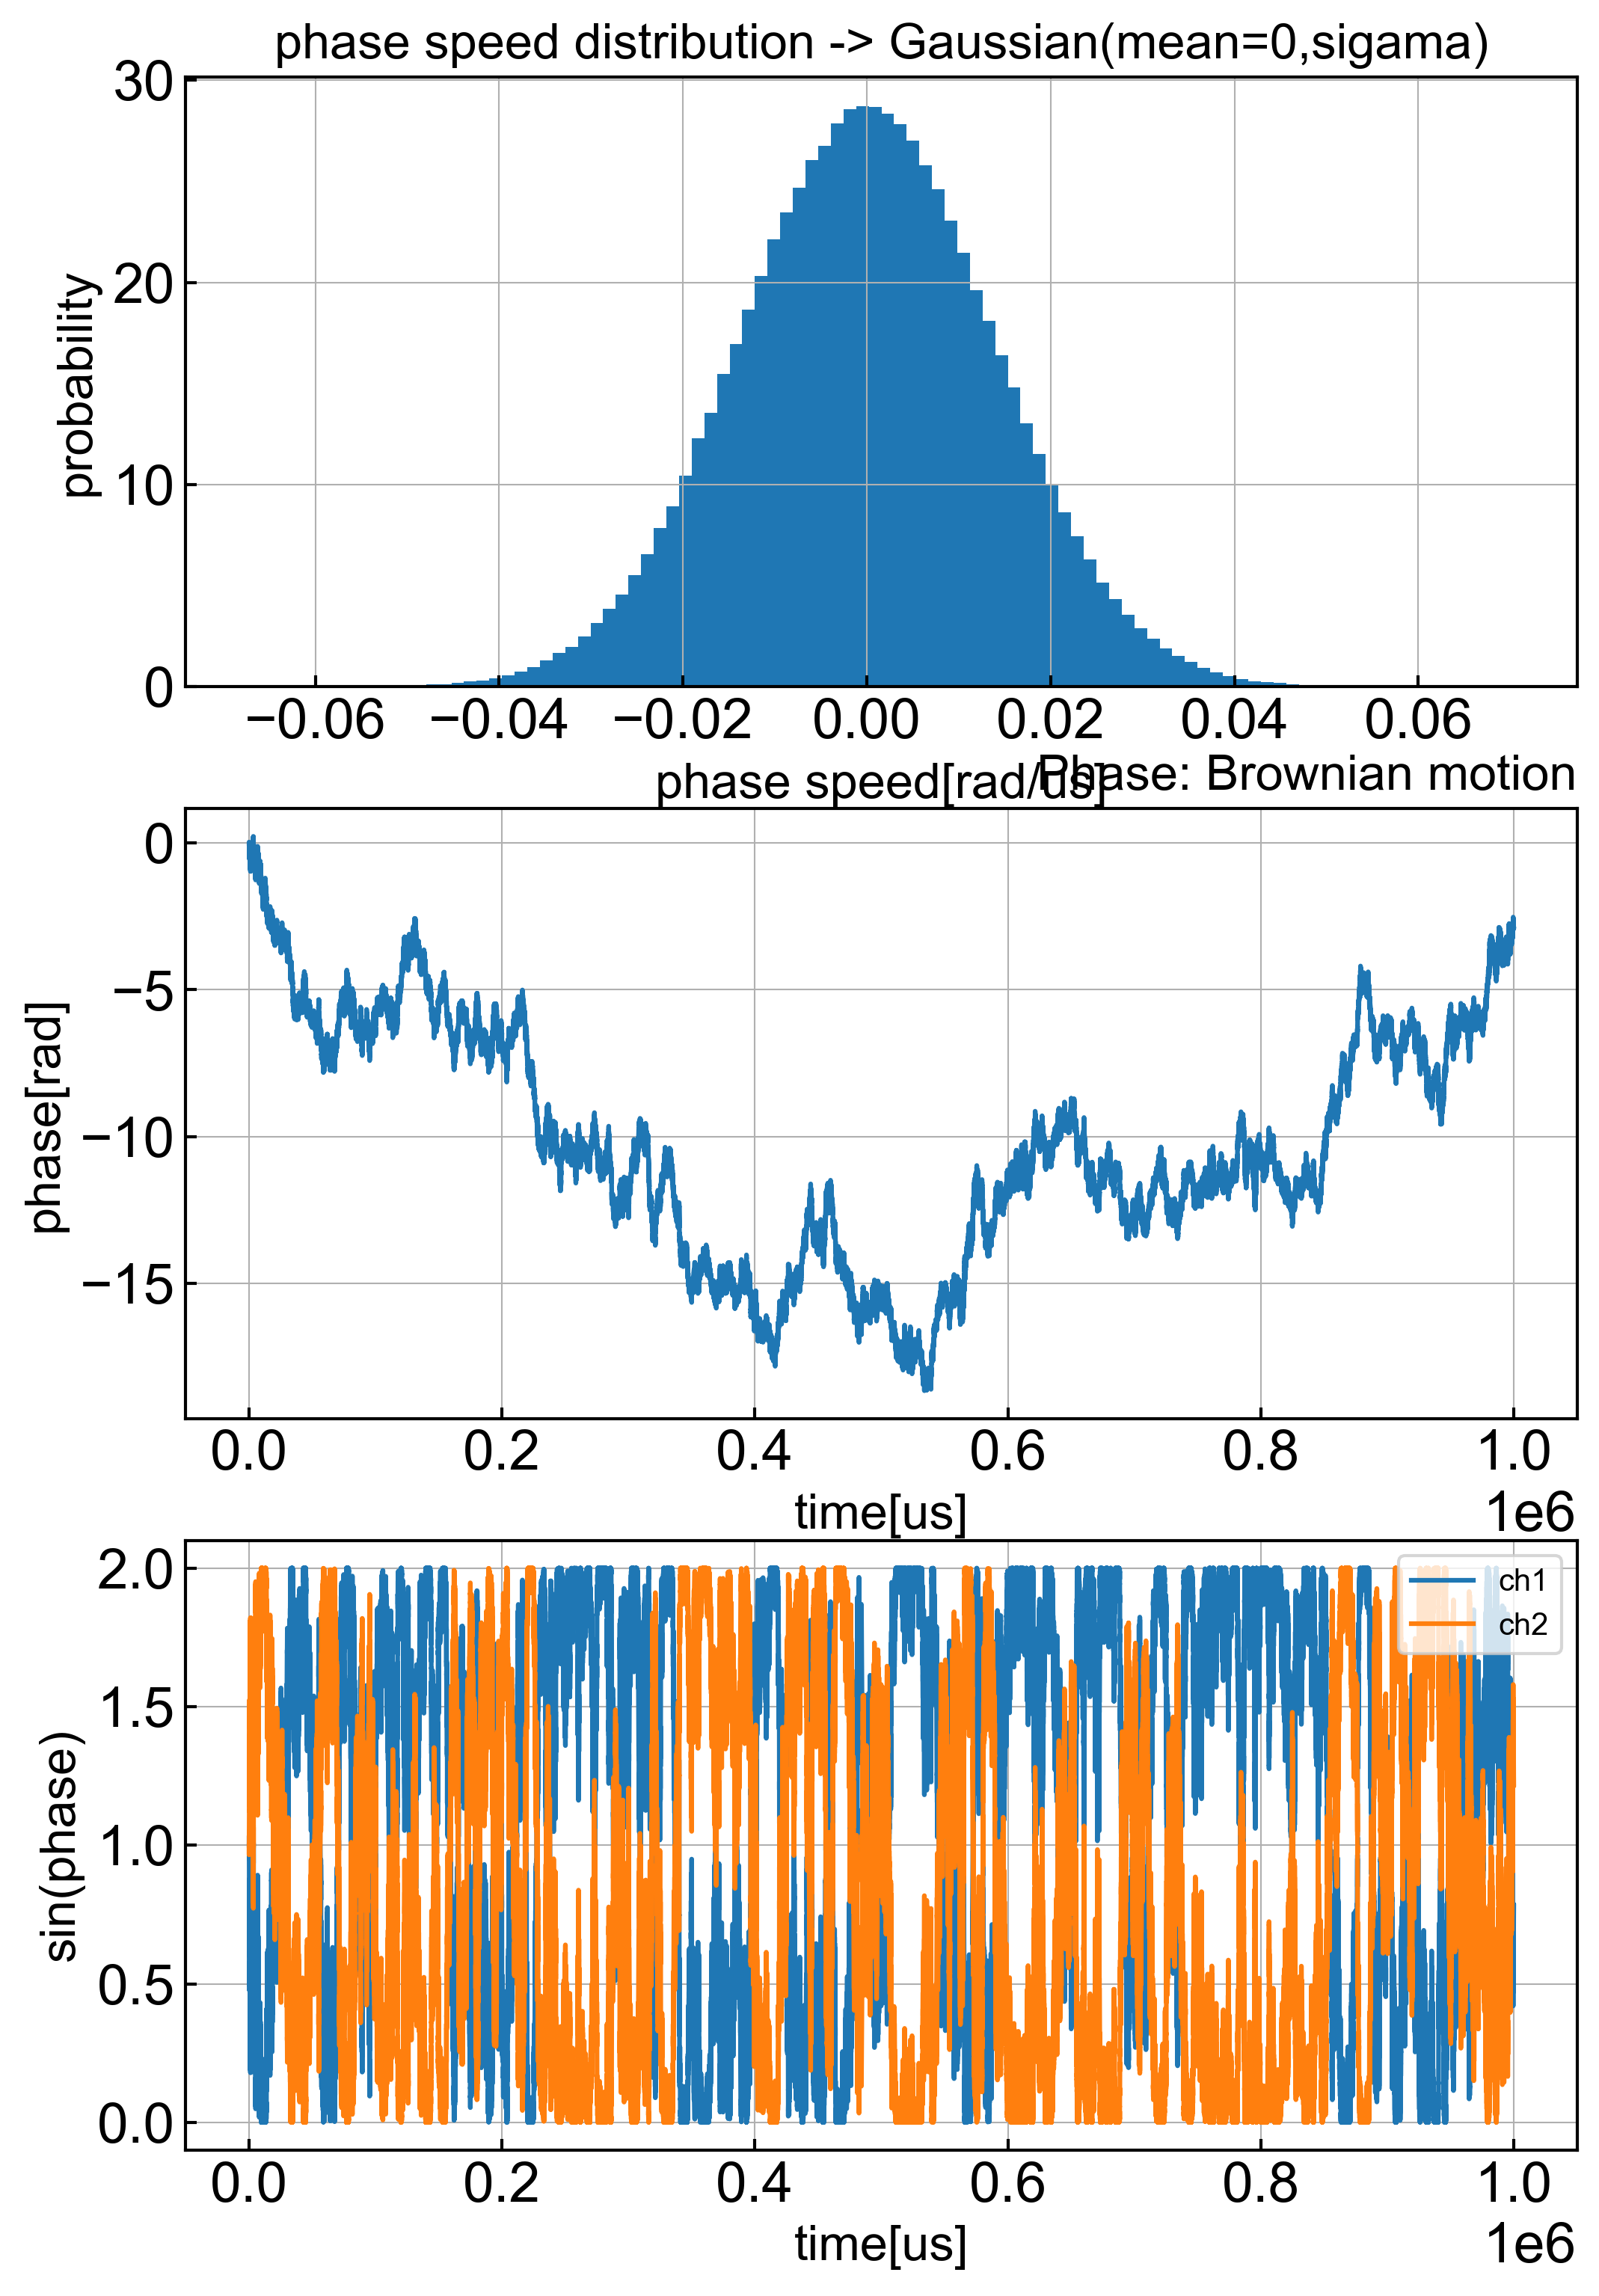

In [54]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [55]:
PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
RAND_NUM=10 # 随机模拟次数
time_axis=np.arange(0,1e5,1) #1us分辨率，len=1e5us  SR=1M
time_exposure=1000
RAND_SEED=2025

如果相位噪声满足独立随机分布，那么用var评估比较好，因为其关于时间（采样点）是线性的；

In [56]:
def crb(tau,with_prior):
    mu=SIG_AMP*2
    V=GAMMY
    sigma=PHASE_SEEPD
    D=sigma*sigma
    ka=0
    a=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
    i_eff=mu*tau*np.exp(-D*tau)
    i_prio=1/(sigma*sigma*tau+ka/mu/V/V)
    i_prio=1/(sigma*sigma*tau+a)
    if with_prior:
        return i_prio+i_eff
    else:
        return i_eff

c1_,c2_,c3_,c4_='#f1ddbf', '#525e75', '#78938a', '#92ba92'
c5,c1,c2,c3,c4="#d9042b","#730220","#03658c","#f29f05","#f27b50"


In [57]:
V0=1
def func_diffusion(tau,mu,D=PHASE_SEEPD**2):
    return D*tau
def func_shot_noise(tau,mu,D=PHASE_SEEPD**2):
    return 1/(mu*tau)
def func_without_prior(tau,mu,D=PHASE_SEEPD**2):
    return 1/(mu*tau*np.exp(-D*tau)*V0*V0)+func_diffusion(tau,mu,D)
def func_with_prior(tau,mu,D=PHASE_SEEPD**2):
    a=np.sqrt(D/mu/V0/V0)
    return 1/((mu*tau*np.exp(-D*tau)*V0*V0)+1/(D*tau+a))+func_diffusion(tau,mu,D)
def func_sigma_inf(tau,mu,D=PHASE_SEEPD**2):
    return np.sqrt(D/mu/V0/V0)
def func_tau_opt(mu,D=PHASE_SEEPD**2):
    return 1/np.sqrt(mu*D)

### 正文无模拟点

## 3d图

In [58]:
# # 3D 曲线：以 tau 为横轴、mu 为纵轴、函数值为 z，仅显示 4 条曲线
# # Nature journal style 3D plot - Enhanced cross-section visualization
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy import interpolate
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from matplotlib.patches import ConnectionPatch

# # %matplotlib tk

# # Colors
# c1_ = '#FFE5CC'
# c2 = '#1f77b4'
# c2_ = '#5DA5DA'
# c3 = '#ff7f0e'
# c4 = '#2ca02c'
# c5 = '#d62728'

# # Set Nature-style font parameters
# plt.rcParams.update({
#     'font.family': 'Arial',
#     'font.size': 12,
#     'axes.labelsize': 16,
#     'axes.titlesize': 16,
#     'xtick.labelsize': 18,
#     'ytick.labelsize': 18,
#     'legend.fontsize': 10,
#     'figure.dpi': 300,
#     'savefig.dpi': 300,
#     'axes.linewidth': 1.0,
#     'grid.linewidth': 0.5,
#     'lines.linewidth': 1.5,
#     'xtick.major.width': 1.0,
#     'ytick.major.width': 1.0,
#     'xtick.direction': 'in',
#     'ytick.direction': 'in',
# })

# # 采样范围
# tau = np.linspace(1, 10**3.5, 1000)
# mu_list = [1,2,3,4,5,6,7,8]

# # Create figure
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')

# # 创建 tau 和 mu 的网格
# tau_surf = np.logspace(0, 3.5, 100)
# mu_surf = np.logspace(np.log10(mu_list[0]), np.log10(mu_list[-1]), 200)
# Tau_grid, Mu_grid = np.meshgrid(tau_surf, mu_surf)

# # 计算两个函数在网格上的值
# Z_without_prior = np.zeros_like(Tau_grid)
# Z_with_prior = np.zeros_like(Tau_grid)

# for i in range(len(mu_surf)):
#     Z_without_prior[i, :] = func_without_prior(tau_surf, mu_surf[i])
#     Z_with_prior[i, :] = func_with_prior(tau_surf, mu_surf[i])

# # 绘制三维曲面
# surf1 = ax.plot_surface(np.log10(Tau_grid), np.log10(Mu_grid), np.log10(Z_without_prior),
#                         alpha=0.1, rstride=3, cstride=3, linewidth=0,
#                         antialiased=True, color=c5)
# surf1._facecolors2d = surf1._facecolor3d
# surf1._edgecolors2d = surf1._edgecolor3d

# surf2 = ax.plot_surface(np.log10(Tau_grid), np.log10(Mu_grid), np.log10(Z_with_prior),
#                         alpha=0.1, rstride=3, cstride=3, linewidth=0,
#                         antialiased=True, color=c2)
# surf2._facecolors2d = surf2._facecolor3d
# surf2._edgecolors2d = surf2._edgecolor3d

# # 坐标范围（保持与方框一致）
# _mu_min = np.log10(mu_list[0])
# _mu_max = np.log10(mu_list[-1])
# _x_min, _x_max = 0, 3.5
# _z_min, _z_max = -2.6, 0

# # 在 yz 平面上添加曲线
# _mu_l = np.linspace(10**_mu_min, 10**(_mu_max), 1000)
# z_sigma_info = func_sigma_inf(tau, _mu_l)
# z_without_sigma_info = func_without_prior(1, _mu_l)
# _index_si = (z_sigma_info >= 10**(_z_min)) & (z_sigma_info <= 10**(_z_max))
# _index_wo_si = (z_without_sigma_info >= 10**(_z_min)) & (z_without_sigma_info <= 10**(_z_max))

# ax.plot(np.full_like(_mu_l[_index_si], 0), np.log10(_mu_l[_index_si]), 
#         np.log10(z_sigma_info[_index_si]), lw=2.2, color=c2, linestyle='-', alpha=0.9)
# ax.plot(np.full_like(_mu_l[_index_wo_si], 0), np.log10(_mu_l[_index_wo_si]), 
#         np.log10(z_without_sigma_info[_index_wo_si]), lw=2.2, color=c5, linestyle='--', alpha=0.9)

# # 设置横截面的 mu 值
# cross_section_mu = 8
# mu_log = np.log10(cross_section_mu)

# # ===== ENHANCED CROSS-SECTION VISUALIZATION (Similar to image style c or f) =====
# # Create a rectangular frame with dashed boundaries and shaded interior

# # Define cross-section plane coordinates
# y_val = mu_log
# x_range = np.linspace(_x_min, _x_max, 2000)
# z_range = np.linspace(_z_min, _z_max, 2000)

# # Create mesh for the plane
# X_plane, Z_plane = np.meshgrid(x_range, z_range)
# Y_plane = np.full_like(X_plane, y_val)

# # Draw semi-transparent plane with a beige/cream color
# plane = ax.plot_surface(X_plane, Y_plane, Z_plane, 
#                         alpha=0.15,
#                         antialiased=True,
#                         color='#F5DEB3',  # Wheat/beige color
#                         linewidth=0)

# # Draw the boundary frame with dashed lines (similar to image styles)
# # # Bottom edge
# # ax.plot([_x_min, _x_max], [y_val, y_val], [_z_min, _z_min], 
# #         'k--', linewidth=2, alpha=0.8)
# # # Top edge
# # ax.plot([_x_min, _x_max], [y_val, y_val], [_z_max, _z_max], 
# #         'k--', linewidth=2, alpha=0.8)
# # # Left edge
# # ax.plot([_x_min, _x_min], [y_val, y_val], [_z_min, _z_max], 
# #         'k--', linewidth=2, alpha=0.8)
# # # Right edge
# # ax.plot([_x_max, _x_max], [y_val, y_val], [_z_min, _z_max], 
# #         'k--', linewidth=2, alpha=0.8)

# # Add corner markers for emphasis (optional, similar to image style)
# corner_size = 0.15
# corners = [
#     (_x_min, _z_min), (_x_max, _z_min), (_x_min, _z_max), (_x_max, _z_max)
# ]
# # for cx, cz in corners:
# #     ax.scatter([cx], [y_val], [cz], color='black', s=30, alpha=0.8, zorder=10)

# # 锁定坐标轴范围，保证与方框重合
# ax.set_xlim3d(_x_min, _x_max)
# ax.set_ylim3d(_mu_min, _mu_max)
# ax.set_zlim3d(_z_min, _z_max)

# # 绘制横截面上的曲线
# curves = []
# z1 = func_without_prior(tau, cross_section_mu)
# z2 = func_with_prior(tau, cross_section_mu)
# curves.append(('Without prior', cross_section_mu, tau, z1, '--'))
# curves.append(('With prior', cross_section_mu, tau, z2, '-'))

# for idx, (kind, mu_i, x_tau, z_val, linestyle) in enumerate(curves):
#     y_mu = np.full_like(x_tau, mu_i)
#     curve_color = c5 if 'Without' in kind else c2
#     ax.plot(np.log10(x_tau), np.log10(y_mu), np.log10(z_val), 
#             lw=0.7, color=curve_color, linestyle=linestyle,
#             label=f'{kind}, μ={mu_i:.1f}', alpha=0.9, zorder=15)

# # Nature-style axis settings
# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False

# for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
#     axis._axinfo["grid"].update({
#         "color": "#808080",
#         "linestyle": "-",
#         "linewidth": 0.1,
#         "alpha": 0.2
#     })
#     axis._axinfo["axisline"]["linewidth"] = 1.2
#     axis.pane.set_edgecolor('none')

# ax.tick_params(axis='x', which='major', direction='in', pad=8, length=4, width=1.0)
# ax.tick_params(axis='y', which='major', direction='in', pad=8, length=4, width=1.0)
# ax.tick_params(axis='z', which='major', direction='in', pad=8, length=4, width=1.0)

# # Axis labels
# ax.set_xlabel('Integration time $\\tau$ / $\\mu$s', labelpad=15, fontsize=18, fontweight='normal')
# ax.set_xticks([0, 1, 2, 3])
# ax.set_xticklabels(['$10^{0}$', '$10^{1}$', '$10^{2}$', '$10^{3}$'], fontsize=14)

# mu_label_list = [1,2,3,4,5,6,7,8]
# ax.set_ylabel('Photon flux $\\mu$ / Mcps', labelpad=15, fontsize=18, fontweight='normal')
# ax.set_yticks([np.log10(mu) for mu in mu_label_list])
# ax.set_yticklabels([f'{mu:.0f}' for mu in mu_label_list], fontsize=14)

# ax.set_zlabel('Residual phase variance (rad$^2$)', labelpad=15, fontsize=18, fontweight='normal')
# ax.set_zticks([-0, -1, -2])
# ax.set_zticklabels(['$10^{0}$', '$10^{-1}$', '$10^{-2}$'], fontsize=14)

# # # 自定义 z 轴：将刻度与标签移动到 x=_x_min, y=_mu_min 处
# # for t in ax.zaxis.get_ticklines():
# #     t.set_alpha(0)
# # for t in ax.zaxis.get_ticklabels():
# #     t.set_alpha(0)
# # _z_ticks = [0, -1, -2]
# # _z_ticklabels = ['$10^{0}$', '$10^{-1}$', '$10^{-2}$']
# # _z_axis_line = np.linspace(_z_min, _z_max, 50)
# # # ax.plot(np.full_like(_z_axis_line, _x_min), np.full_like(_z_axis_line, _mu_min), _z_axis_line,
# # #         color='k', lw=1.0, zorder=21)
# # for _z_val, _lbl in zip(_z_ticks, _z_ticklabels):
# #     ax.scatter([_x_max], [_mu_min], [_z_val], color='k', s=22, zorder=22, marker='_')
# #     ax.text(_x_max+0.05, _mu_min, _z_val, _lbl, fontsize=13, ha='left', va='center', zorder=23)
# # ax.text(_x_max+1.12, _mu_min, (_z_min+_z_max)/2, 'Residual phase variance (rad$^2$)',
# #         fontsize=18,zdir='z', va='center', ha='left', zorder=23)

# # Draw a full bounding box using the locked axis limits
# _x_lim = (_x_min, _x_max)
# _y_lim = (_mu_min, _mu_max)
# _z_lim = (_z_min, _z_max)
# _box_edges = [
#     ((_x_lim[1], _x_lim[1]), (_y_lim[0], _y_lim[0]), (_z_lim[0], _z_lim[1])),
# # x=max, y=min vertical
#     ((_x_lim[0], _x_lim[0]), (_y_lim[1], _y_lim[1]), (_z_lim[0], _z_lim[1])),
# # x=min, y=max vertical
#     ((_x_lim[1], _x_lim[1]), (_y_lim[1], _y_lim[1]), (_z_lim[0], _z_lim[1])),
# # x=max, y=max vertical
#     ((_x_lim[0], _x_lim[1]), (_y_lim[0], _y_lim[0]), (_z_lim[0], _z_lim[0])),
# # bottom front edge
#     ((_x_lim[0], _x_lim[1]), (_y_lim[1], _y_lim[1]), (_z_lim[0], _z_lim[0])),
# # bottom back edge
#     ((_x_lim[0], _x_lim[1]), (_y_lim[1], _y_lim[1]), (_z_lim[1], _z_lim[1])),
# # top back edge
#     ((_x_lim[0], _x_lim[0]), (_y_lim[0], _y_lim[1]), (_z_lim[0], _z_lim[0])),
# # left edge at z_min
#     ((_x_lim[1], _x_lim[1]), (_y_lim[0], _y_lim[1]), (_z_lim[0], _z_lim[0])),
# # right edge at z_min
#     ((_x_lim[1], _x_lim[1]), (_y_lim[0], _y_lim[1]), (_z_lim[1], _z_lim[1])),
# # right edge at z_max
#     ((_x_lim[0], _x_lim[0]), (_y_lim[0], _y_lim[0]), (_z_lim[0], _z_lim[1])),
# # x=min, y=min vertical
#     ((_x_lim[0], _x_lim[1]), (_y_lim[0], _y_lim[0]), (_z_lim[1], _z_lim[1])),
# # top front edge
#     ((_x_lim[0], _x_lim[0]), (_y_lim[0], _y_lim[1]), (_z_lim[1], _z_lim[1])),
# # left edge at z_max
#  ]
# for _xs, _ys, _zs in _box_edges:
#     ax.plot(_xs, _ys, _zs, color='gray', linewidth=0.7, alpha=0.5, zorder=20)

# # View angle
# # ax.view_init(elev=25, azim=205, roll=-1.6)
# ax.set_proj_type('ortho')
# # ax.view_init(elev=10, azim=-145, roll=0)
# ax.view_init(elev=25, azim=205, roll=-1.6)

# z_label = ax.zaxis.label
# z_label.set_visible(True)
# ax.zaxis._axinfo['label']['space_factor'] = 2.5

# # Add asymptotic scaling labels
# _mu_mid = 10**((_mu_min + _mu_max) / 2)
# _z_sigma_mid = func_sigma_inf(1, _mu_mid)
# _z_wo_mid = func_without_prior(1, _mu_mid)

# ax.text(0.05, np.log10(_mu_mid)+0.1, np.log10(_z_sigma_mid) + 0.1,
#         '$\\propto \\mu^{-1/2}$', color=c2, fontsize=12)
# ax.text(0.05, np.log10(_mu_mid)+0.1, np.log10(_z_wo_mid),
#         '$\\propto \\mu^{-1}$', color=c5, fontsize=12)

# # Inset plot
# inset_pos = [0.32, 0.95, 0.35, 0.35]
# ax_inset = fig.add_axes(inset_pos)

# bandwith_tau = 1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP))
# mu = SIG_AMP*2
# phase_var_limit = PHASE_SEEPD/np.sqrt(2*SIG_AMP)
# adv_up = phase_var_limit*2
# adv_low = phase_var_limit*1e-5

# ax_inset.plot(time_axis, func_diffusion(time_axis, mu), '-.', label='Phase diffusion', color=c3)
# ax_inset.plot(time_axis[1:], func_shot_noise(time_axis[1:], mu), '-.', label='SQL for static measurement', color=c4)
# ax_inset.loglog(time_axis, func_without_prior(time_axis, mu),'--',color=c5, label='$\\sigma^2_{Conv}$',lw=2.5,alpha=0.9)
# ax_inset.loglog(time_axis, func_with_prior(time_axis, mu), '-', color=c2, label='$\\sigma^2_{Bay}$',lw=2.5,alpha=0.9)
# ax_inset.hlines(phase_var_limit, 1, bandwith_tau, linestyles=':', color='k', linewidth=1,label="SQL for tracking ($\\sigma^2_{SQL}$)")
# # ax_inset.text(bandwith_tau*1e-1, phase_var_limit, '$\\sigma_{\\infty}^2$', ha='center', va='top', fontsize=14, color='k')

# ax_inset.fill_between(time_axis[time_axis<=bandwith_tau], adv_low, adv_up, color=c1_, alpha=0.6, label='FI advantage')
# # ax_inset.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_, linewidth=0.7)
# ax_inset.text(bandwith_tau, 40e-4, '$τ_{c}$', ha='center', va='bottom', fontsize=14, color=c2_)

# ax_inset.set_xscale('log')
# ax_inset.set_yscale('log')
# ax_inset.set_ylim(25e-4, 1)
# ax_inset.set_xlim(1, 5e3)
# ax_inset.grid(alpha=0.7)
# ax_inset.set_xlabel('$\\tau$ / $\\mu$s', fontsize=14, fontweight='normal')
# ax_inset.set_ylabel('Variance (rad$^2$)', fontsize=14, fontweight='normal')

# ax_inset.tick_params(axis='both', which='major', labelsize=16, direction='in', length=3, width=0.8)
# ax_inset.tick_params(axis='both', which='minor', labelsize=16, direction='in', length=2, width=0.6)

# ax_inset.patch.set_facecolor('white')
# ax_inset.patch.set_alpha(0.98)

# ax_inset.legend(loc='upper right', fontsize=10, frameon=True, 
#                 framealpha=0.9, edgecolor='#CCCCCC', 
#                 fancybox=False, shadow=False)

# for spine in ax_inset.spines.values():
#     spine.set_edgecolor('#000000')
#     spine.set_linewidth(1.2)
#     spine.set_zorder(2)

# # Connection arrow
# conn_arrow_style = dict(
#     arrowstyle="-|>",
#     color="#666666",
#     linewidth=2,
#     alpha=0.7,
#     linestyle="--",
#     connectionstyle="arc3,rad=0.2"
#  )

# inset_left = inset_pos[0]
# inset_bottom = inset_pos[1]
# inset_width = inset_pos[2]

# conn_arrow = ConnectionPatch(
#     xyA=(0.5, 0.7),
#     xyB=(inset_left+inset_width/2, inset_bottom-0.1),
#     coordsA="figure fraction",
#     coordsB="figure fraction",
#     **conn_arrow_style
# )
# fig.add_artist(conn_arrow)

# fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

# plt.savefig('fig2_3d_final.pdf', bbox_inches='tight', pad_inches=1)

/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_2116/2000616354.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


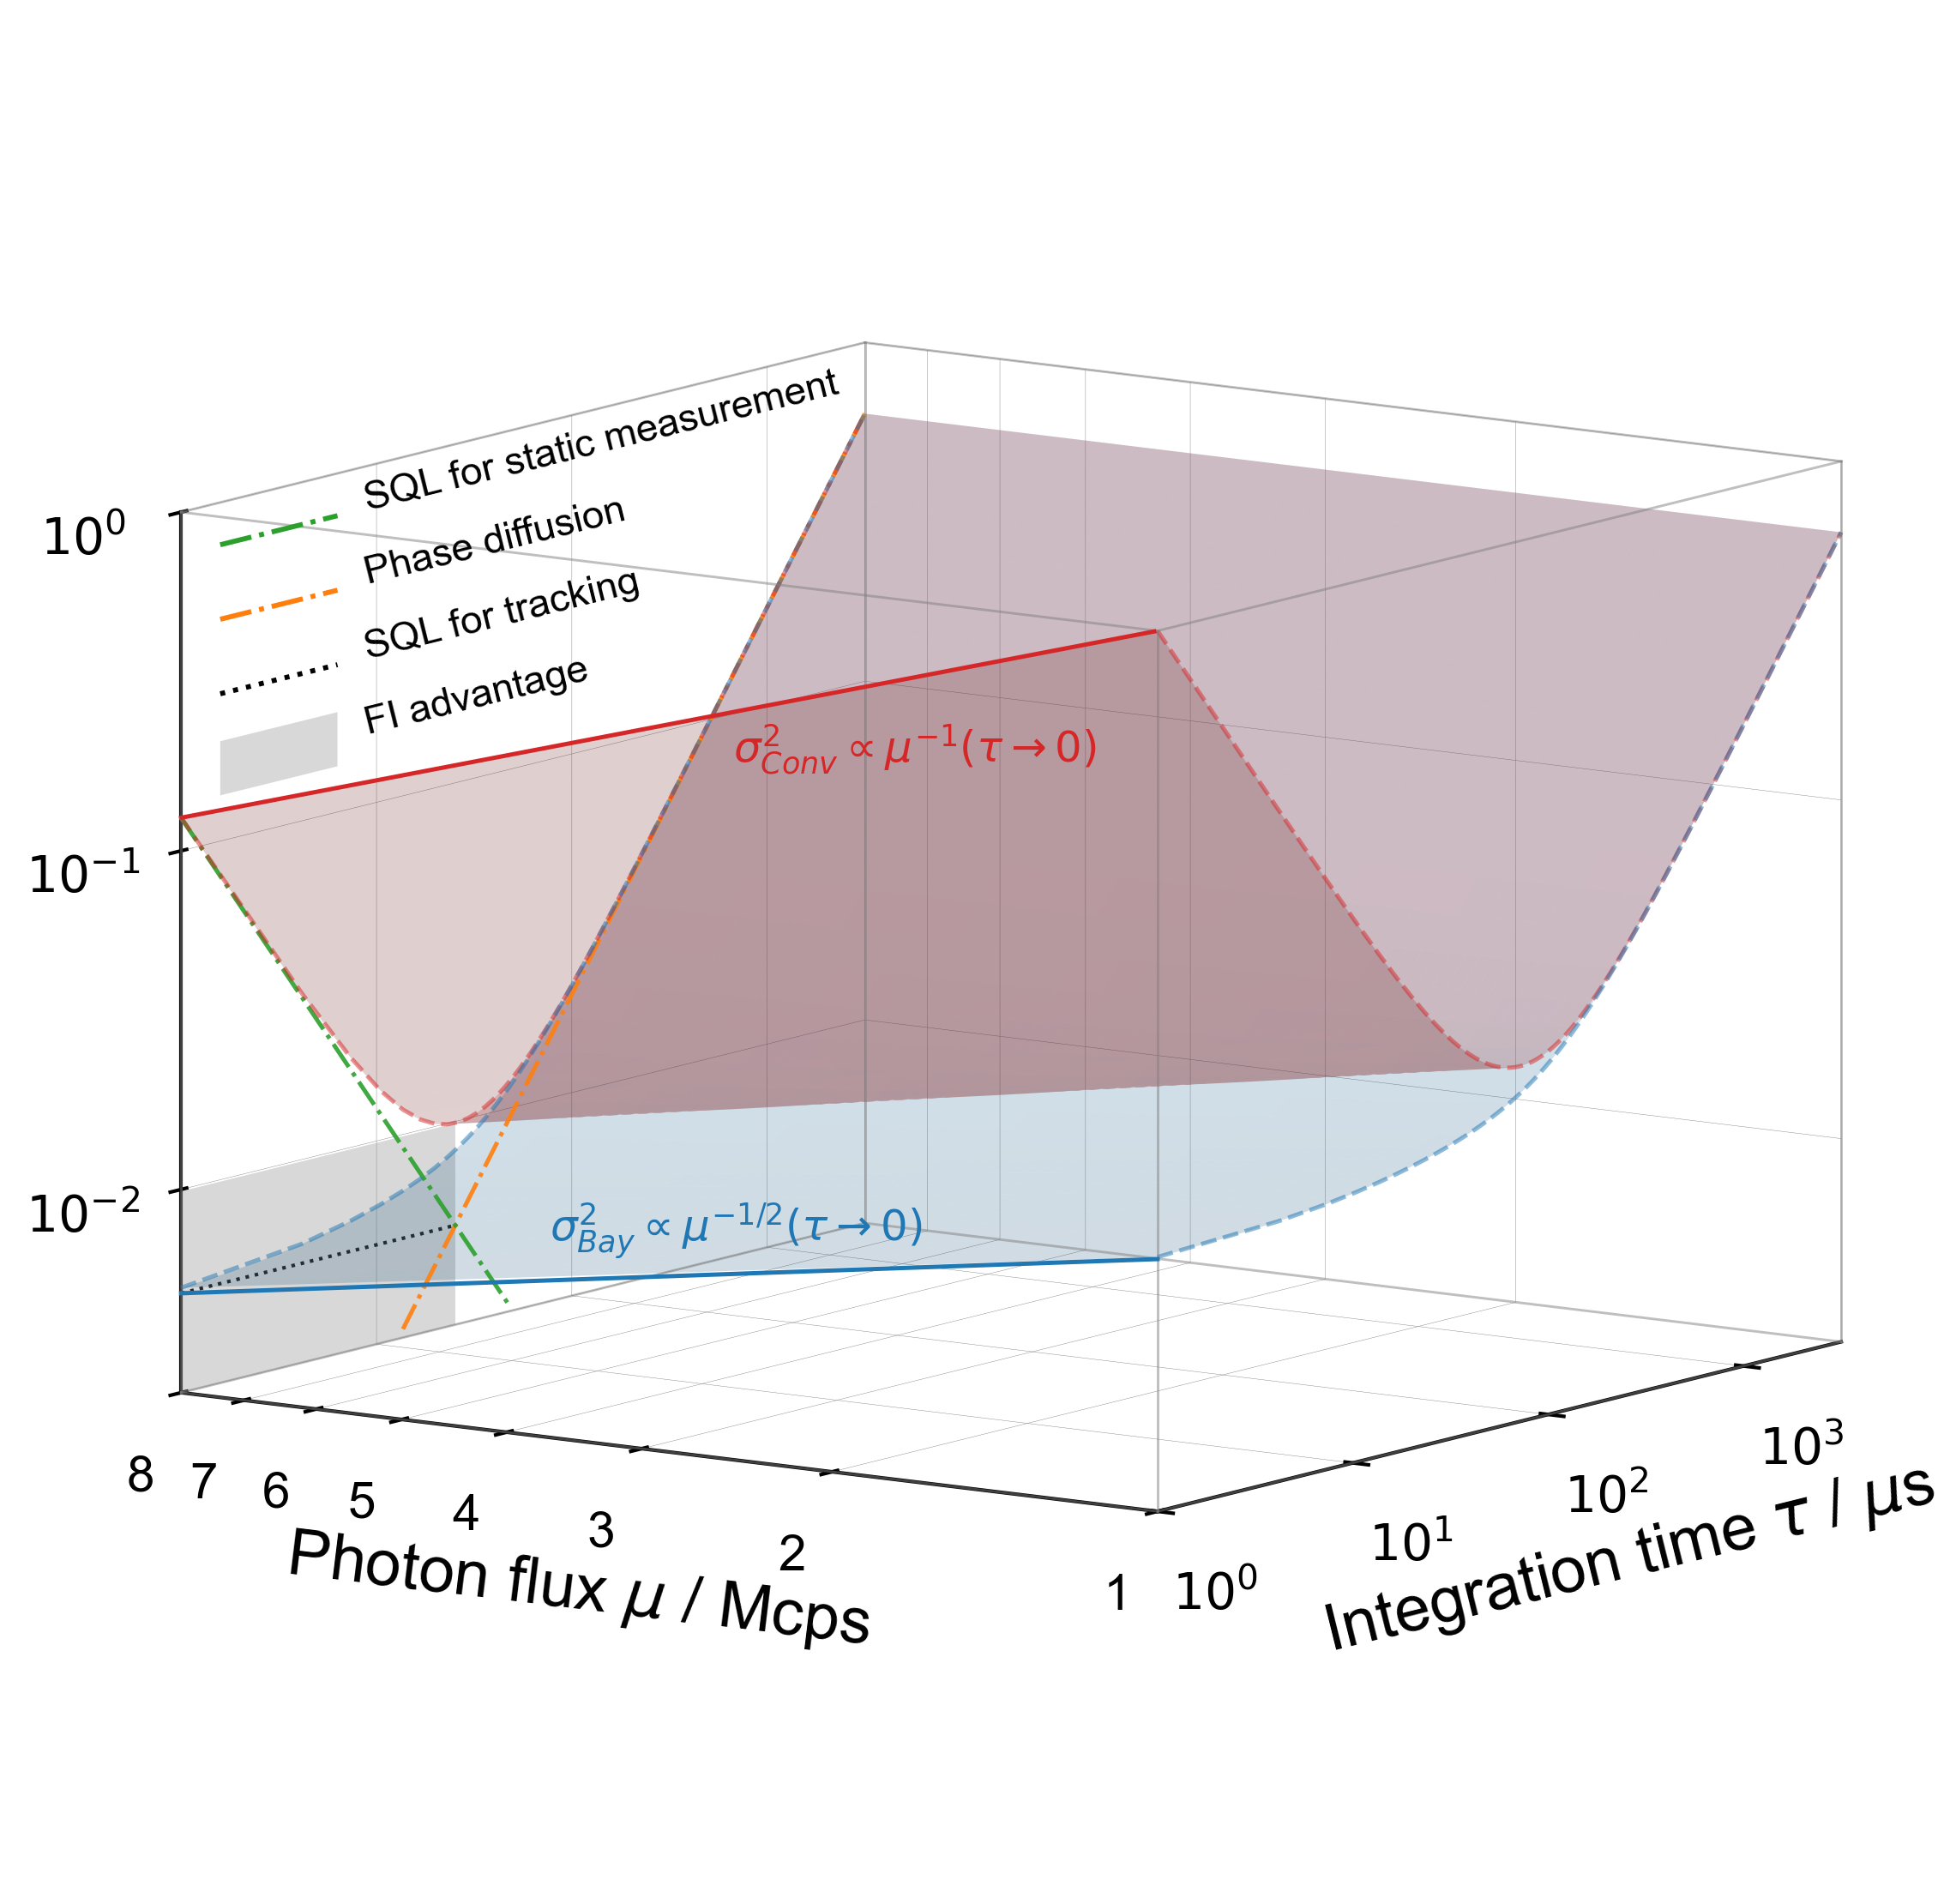

In [201]:
# 3D 曲线：以 tau 为横轴、mu 为纵轴、函数值为 z，仅显示 4 条曲线
# Nature journal style 3D plot - Enhanced cross-section visualization
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import ConnectionPatch

# %matplotlib tk

# Colors
c1_ = '#FFE5CC'
c2 = '#1f77b4'
c2_ = '#5DA5DA'
c3 = '#ff7f0e'
c4 = '#2ca02c'
c5 = '#d62728'

# Set Nature-style font parameters
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.linewidth': 1.0,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

# 采样范围
tau = np.linspace(1, 10**3.5, 1000)
mu_list = [1,2,3,4,5,6,7,8]

# Create figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 创建 tau 和 mu 的网格
tau_surf = np.logspace(0, 3.5, 100)
mu_surf = np.logspace(np.log10(mu_list[0]), np.log10(mu_list[-1]), 200)
Tau_grid, Mu_grid = np.meshgrid(tau_surf, mu_surf)

# 计算两个函数在网格上的值
Z_without_prior = np.zeros_like(Tau_grid)
Z_with_prior = np.zeros_like(Tau_grid)

for i in range(len(mu_surf)):
    Z_without_prior[i, :] = func_without_prior(tau_surf, mu_surf[i])
    Z_with_prior[i, :] = func_with_prior(tau_surf, mu_surf[i])

# 绘制三维曲面
surf1 = ax.plot_surface(np.log10(Tau_grid), np.log10(Mu_grid), np.log10(Z_without_prior),
                        alpha=0.2, rstride=3, cstride=3, linewidth=0,
                        antialiased=True, color=c5)
surf1._facecolors2d = surf1._facecolor3d
# surf1._edgecolors2d = surf1._edgecolor3d

surf2 = ax.plot_surface(np.log10(Tau_grid), np.log10(Mu_grid), np.log10(Z_with_prior),
                        alpha=0.2, rstride=3, cstride=3, linewidth=0,
                        antialiased=True, color=c2)
surf2._facecolors2d = surf2._facecolor3d
surf2._edgecolors2d = surf2._edgecolor3d

# 坐标范围（保持与方框一致）
_mu_min = np.log10(mu_list[0])
_mu_max = np.log10(mu_list[-1])
_x_min, _x_max = 0, 3.5
_z_min, _z_max = -2.6, 0

# 设置横截面的 mu 值
cross_section_mu = 8
mu_log = np.log10(cross_section_mu)

# ===== ENHANCED CROSS-SECTION VISUALIZATION (Similar to image style c or f) =====
# Create a rectangular frame with dashed boundaries and shaded interior

# Define cross-section plane coordinates
y_val = mu_log
x_range = np.linspace(_x_min, _x_max, 2000)
z_range = np.linspace(_z_min, _z_max, 2000)

# Create mesh for the plane
X_plane, Z_plane = np.meshgrid(x_range, z_range)
Y_plane = np.full_like(X_plane, y_val)

# Draw semi-transparent plane with a beige/cream color
# plane = ax.plot_surface(X_plane, Y_plane, Z_plane, 
#                         alpha=0.15,
#                         antialiased=True,
#                         color='#F5DEB3',  # Wheat/beige color
#                         linewidth=0)

# Add corner markers for emphasis (optional, similar to image style)
# corner_size = 0.15
# corners = [
#     (_x_min, _z_min), (_x_max, _z_min), (_x_min, _z_max), (_x_max, _z_max)
# ]
# for cx, cz in corners:
#     ax.scatter([cx], [y_val], [cz], color='black', s=30, alpha=0.8, zorder=10)

# 锁定坐标轴范围，保证与方框重合
ax.set_xlim3d(_x_min, _x_max)
ax.set_ylim3d(_mu_min, _mu_max)
ax.set_zlim3d(_z_min, _z_max)
#---------
# 绘制横截面上的曲线
bandwith_tau = 1/(PHASE_SEEPD*np.sqrt(cross_section_mu))
mu = cross_section_mu
phase_var_limit = PHASE_SEEPD/np.sqrt(cross_section_mu)
adv_up = phase_var_limit*2
adv_low = 10**_z_min

# 在横截面上绘制 FI advantage 区域和 SQL 线
_x_band = [np.log10(1), np.log10(bandwith_tau)]
_z_band = [np.log10(adv_low), np.log10(adv_up)]
_rect = [
    (_x_band[0], mu_log, _z_band[0]),
    (_x_band[1], mu_log, _z_band[0]),
    (_x_band[1], mu_log, _z_band[1]),
    (_x_band[0], mu_log, _z_band[1])
]
ax.add_collection3d(Poly3DCollection([_rect], facecolor='gray', alpha=0.3, edgecolor='none', zorder=10))
ax.plot(_x_band, [mu_log, mu_log], [np.log10(phase_var_limit)]*2,
        linestyle=':', color='k', linewidth=1.0, label='SQL for tracking')

curves = []
z_diffusion=func_diffusion(tau, cross_section_mu)
z_shot_noise=func_shot_noise(tau, cross_section_mu)
z1 = func_without_prior(tau, cross_section_mu)
z2 = func_with_prior(tau, cross_section_mu)
curves.append(('Phase diffusion', cross_section_mu, tau, z_diffusion, '-.',c3))
curves.append(('SQL for static measurement', cross_section_mu, tau, z_shot_noise, '-.',c4))
curves.append(('Conv', cross_section_mu, tau, z1, '--',c5))
curves.append(('Bay', cross_section_mu, tau, z2, '--',c2))

for idx, (kind, mu_i, x_tau, z_val, linestyle,curve_color) in enumerate(curves):
    y_mu = np.full_like(x_tau, mu_i)
    _index=(np.log10(z_val)>_z_min)&(np.log10(z_val)<_z_max)
    _alpha = 0.5 if 'Conv' in kind or 'Bay' in kind else 0.9
    ax.plot(np.log10(x_tau)[_index], np.log10(y_mu)[_index], np.log10(z_val)[_index], 
            lw=1.2, color=curve_color, linestyle=linestyle,
            label=f'{kind}', alpha=_alpha, zorder=15)
    
####
curves = []
z1 = func_without_prior(tau, 1)
z2 = func_with_prior(tau, 1)
curves.append(('Conv', 1, tau, z1, '--',c5))
curves.append(('Bay', 1, tau, z2, '--',c2))

for idx, (kind, mu_i, x_tau, z_val, linestyle,curve_color) in enumerate(curves):
    y_mu = np.full_like(x_tau, mu_i)
    # _index=(np.log10(z_val)>_z_min)&(np.log10(z_val)<_z_max)
    ax.plot(np.log10(x_tau)[_index], np.log10(y_mu)[_index], np.log10(z_val)[_index], 
            lw=1.2, color=curve_color, linestyle=linestyle,
            label=f'{kind}', alpha=0.5, zorder=15)

# 将图例绘制在横截面平面上（y = mu_log）
_leg_x0 = _x_min + 0.2
_leg_x1 = _x_min + 0.8
_leg_z_start = _z_max - 0.125
_leg_dz = 0.22
_legend_items = [
    ('SQL for static measurement', c4, '-.'),
    ('Phase diffusion', c3, '-.'),
    # ('Conv', c5, '--'),
    # ('Bay', c2, '-'),
    ('SQL for tracking', 'k', ':'),
    ('FI advantage', c1_, '-'),
 ]
for _i, (_lbl, _col, _ls) in enumerate(_legend_items):
    _z_pos = _leg_z_start - _i*_leg_dz
    if _lbl == 'FI advantage':
        _z_half = 0.08
        _rect_leg = [
            (_leg_x0, mu_log, _z_pos - _z_half),
            (_leg_x1, mu_log, _z_pos - _z_half),
            (_leg_x1, mu_log, _z_pos + _z_half),
            (_leg_x0, mu_log, _z_pos + _z_half),
        ]
        ax.add_collection3d(Poly3DCollection([_rect_leg], facecolor='gray', edgecolor='none', alpha=0.3, zorder=25))
    else:
        ax.plot([_leg_x0, _leg_x1], [mu_log, mu_log], [_z_pos, _z_pos],
                color=_col, linestyle=_ls, linewidth=1.4, zorder=25)
    ax.text(_leg_x1 + 0.12, mu_log, _z_pos, _lbl, fontsize=11, ha='left', va='baseline', zorder=25, zdir='x')



# Nature-style axis settings
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo["grid"].update({
        "color": "#808080",
        "linestyle": "-",
        "linewidth": 0.1,
        "alpha": 1
    })
    axis._axinfo["axisline"]["linewidth"] = 0.1
    axis.pane.set_edgecolor('none')

ax.tick_params(axis='x', which='major', direction='in', pad=8, length=4, width=1.0)
ax.tick_params(axis='y', which='major', direction='in', pad=8, length=4, width=1.0)
ax.tick_params(axis='z', which='major', direction='in', pad=8, length=4, width=1.0)

# Axis labels
ax.set_xlabel('Integration time $\\tau$ / $\\mu$s', labelpad=15, fontsize=18, fontweight='normal')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['$10^{0}$', '$10^{1}$', '$10^{2}$', '$10^{3}$'], fontsize=14)

mu_label_list = [1,2,3,4,5,6,7,8]
ax.set_ylabel('Photon flux $\\mu$ / Mcps', labelpad=15, fontsize=18, fontweight='normal')
ax.set_yticks([np.log10(mu) for mu in mu_label_list])
ax.set_yticklabels([f'{mu:.0f}' for mu in mu_label_list], fontsize=14)

ax.set_zlabel('Phase variance (rad$^2$)', labelpad=15, fontsize=18, fontweight='normal')
ax.set_zticks([-0, -1, -2])
ax.set_zticklabels(['$10^{0}$', '$10^{-1}$', '$10^{-2}$'], fontsize=14)

# # 自定义 z 轴：将刻度与标签移动到 x=_x_min, y=_mu_min 处
# for t in ax.zaxis.get_ticklines():
#     t.set_alpha(0)
# for t in ax.zaxis.get_ticklabels():
#     t.set_alpha(0)
# _z_ticks = [0, -1, -2]
# _z_ticklabels = ['$10^{0}$', '$10^{-1}$', '$10^{-2}$']
# _z_axis_line = np.linspace(_z_min, _z_max, 50)
# # ax.plot(np.full_like(_z_axis_line, _x_min), np.full_like(_z_axis_line, _mu_min), _z_axis_line,
# #         color='k', lw=1.0, zorder=21)
# for _z_val, _lbl in zip(_z_ticks, _z_ticklabels):
#     ax.scatter([_x_max], [_mu_min], [_z_val], color='k', s=22, zorder=22, marker='_')
#     ax.text(_x_max+0.05, _mu_min, _z_val, _lbl, fontsize=13, ha='left', va='center', zorder=23)
# ax.text(_x_max+1.12, _mu_min, (_z_min+_z_max)/2, 'Residual phase variance (rad$^2$)',
#         fontsize=18,zdir='z', va='center', ha='left', zorder=23)

# Draw a full bounding box using the locked axis limits
_x_lim = (_x_min, _x_max)
_y_lim = (_mu_min, _mu_max)
_z_lim = (_z_min, _z_max)
_box_edges = [
    ((_x_lim[1], _x_lim[1]), (_y_lim[0], _y_lim[0]), (_z_lim[0], _z_lim[1])),
# x=max, y=min vertical
    ((_x_lim[0], _x_lim[0]), (_y_lim[1], _y_lim[1]), (_z_lim[0], _z_lim[1])),
# x=min, y=max vertical
    ((_x_lim[1], _x_lim[1]), (_y_lim[1], _y_lim[1]), (_z_lim[0], _z_lim[1])),
# x=max, y=max vertical
    ((_x_lim[0], _x_lim[1]), (_y_lim[0], _y_lim[0]), (_z_lim[0], _z_lim[0])),
# bottom front edge
    ((_x_lim[0], _x_lim[1]), (_y_lim[1], _y_lim[1]), (_z_lim[0], _z_lim[0])),
# bottom back edge
    ((_x_lim[0], _x_lim[1]), (_y_lim[1], _y_lim[1]), (_z_lim[1], _z_lim[1])),
# top back edge
    ((_x_lim[0], _x_lim[0]), (_y_lim[0], _y_lim[1]), (_z_lim[0], _z_lim[0])),
# left edge at z_min
    ((_x_lim[1], _x_lim[1]), (_y_lim[0], _y_lim[1]), (_z_lim[0], _z_lim[0])),
# right edge at z_min
    ((_x_lim[1], _x_lim[1]), (_y_lim[0], _y_lim[1]), (_z_lim[1], _z_lim[1])),
# right edge at z_max
    ((_x_lim[0], _x_lim[0]), (_y_lim[0], _y_lim[0]), (_z_lim[0], _z_lim[1])),
# x=min, y=min vertical
    ((_x_lim[0], _x_lim[1]), (_y_lim[0], _y_lim[0]), (_z_lim[1], _z_lim[1])),
# top front edge
    ((_x_lim[0], _x_lim[0]), (_y_lim[0], _y_lim[1]), (_z_lim[1], _z_lim[1])),
# left edge at z_max
 ]
for _xs, _ys, _zs in _box_edges:
    ax.plot(_xs, _ys, _zs, color='gray', linewidth=0.7, alpha=0.5, zorder=20)

# View angle
# ax.view_init(elev=25, azim=205, roll=-1.6)
ax.set_proj_type('ortho')
ax.view_init(elev=10, azim=-145, roll=0)
# ax.view_init(elev=25, azim=205, roll=-1.6)

z_label = ax.zaxis.label
z_label.set_visible(True)
ax.zaxis._axinfo['label']['space_factor'] = 2.5


# 在 yz 平面上添加曲线
_mu_l = np.linspace(10**_mu_min, 10**(_mu_max), 1000)
z_sigma_info = func_sigma_inf(tau, _mu_l)
z_without_sigma_info = func_without_prior(1, _mu_l)
_index_si = (z_sigma_info >= 10**(_z_min)) & (z_sigma_info <= 10**(_z_max))
_index_wo_si = (z_without_sigma_info >= 10**(_z_min)) & (z_without_sigma_info <= 10**(_z_max))

ax.plot(np.full_like(_mu_l[_index_si], 0), np.log10(_mu_l[_index_si]), 
        np.log10(z_sigma_info[_index_si]), lw=1.2, color=c2, linestyle='-', alpha=1, zorder=28)
ax.plot(np.full_like(_mu_l[_index_wo_si], 0), np.log10(_mu_l[_index_wo_si]), 
        np.log10(z_without_sigma_info[_index_wo_si]), lw=1.2, color=c5, linestyle='-', alpha=1, zorder=28)
# Add asymptotic scaling labels
_mu_mid = 10**((_mu_min + _mu_max) / 2)
_z_sigma_mid = func_sigma_inf(1, _mu_mid)
_z_wo_mid = func_without_prior(1, _mu_mid)

ax.text(0.05, np.log10(_mu_mid)+0.12, np.log10(_z_sigma_mid) + 0.05,
        '$\\sigma^2_{Bay}\\propto \\mu^{-1/2}(\\tau\\to0)$', color=c2, fontsize=12, zorder=29,)
ax.text(0.05, np.log10(_mu_mid)-0.05, np.log10(_z_wo_mid)-0.1,
        '$\\sigma^2_{Conv}\\propto \\mu^{-1}(\\tau\\to0)$', color=c5, fontsize=12, zorder=29)
# ax.legend()
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.tight_layout()
plt.savefig('fig2_3d_final.pdf', bbox_inches='tight',pad_inches=1)
plt.savefig('fig2_3d_final.svg', bbox_inches='tight',pad_inches=1)